In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterstats import zonal_stats
import numpy as np
import osmnx as ox
import networkx as nx
import os
import datetime as dt
import glob
import matplotlib.pyplot as plt

In [2]:

def find_raster_files(root_dir, file_extension='xx'):
    raster_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(file_extension):
                raster_files.append(os.path.join(root, file))
    return raster_files

def merge_rasters_with_mask(raster_files):
    src_files_to_mosaic = [rasterio.open(raster) for raster in raster_files]
    
    # Merge data
    mosaic, out_trans = merge(src_files_to_mosaic)
    
    # Update the metadata with the merged data properties
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0]  # Update to match the number of layers in the mosaic
    })
    
    for src in src_files_to_mosaic:
        src.close()
    
    return mosaic, out_trans, out_meta

def compute_zonal_stats(polygons, raster_data, affine, nodata_value=None):
    stats = zonal_stats(polygons, raster_data, affine=affine, stats=['sum'], nodata=nodata_value)
    return stats

TO DO, 8/7:
1. Identify tif files for 1200 timestamp shade data 
2. Merge the 1200 tif files into one tif
3. Convert G_combined into a gdf 
4. Use zonal_stats on gdf 

4.1 0 = shade, 1 = sun
    

I just added a python script to the drive folder I made for you: calculate_shade_metrics_expanded. That includes the raster merge function. What I do is essentially merge all of the relevant raster files (which I identify with the find_raster function). All identified files are opened and merged together to form a large raster. Then I go through all individual polygons in my vector dataset (the sidewalks etc.) and calculate raster statistics. Should also work with linestrings, you might have to add the all_touched parameter https://pythonhosted.org/rasterstats/manual.html#vector-data-sources

The way that I understand it, you’ll have to convert the graph to dataframe, then calculate the raster statistics for each edge (linestring) as a basis for the weight.

Import data

In [8]:
def shade_weights_to_graph(osmid,date,timesteps,graph_path):
    # Load graph: 
    graph_orig = ox.load_graphml(f'{graph_path}')
        
    print('Loaded graph')

    nodes, edges = ox.graph_to_gdfs(graph_orig)

    print('Got nodes, edges gdf')

    # Initialize an empty dictionary
    shade_weights = {}



    for time in timesteps:
        root_directory = f"../results/output/{osmid}/tree_shade/"
        timestr_extension = f'{date}_{time}_LST.tif'
        print(timestr_extension)
        raster_files = find_raster_files(root_directory, timestr_extension)
        print(f'found {len(raster_files)}files to merge')

        mosaic, out_trans, out_meta = merge_rasters_with_mask(raster_files)

        # Ensure polygons are in the same CRS as the raster
        raster_crs = out_meta['crs']
        # if poly.crs != raster_crs:
        #     poly = poly.to_crs(raster_crs)

        # Update metadata for the virtual raster
        out_meta.update({
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans
        })

        # print('Merge successful; Server is sweating a little. Stats are next')

        nodata_value = out_meta.get('nodata', None)

        print(f'Done merging {time}!')

        if edges.crs != raster_crs:
            edges = edges.to_crs(raster_crs)

        # Assuming 'mosaic' is your merged raster data
        stats = compute_zonal_stats(edges, mosaic[0], affine=out_trans, nodata_value=nodata_value)

        # # Add statistics to polygon dataset
        for stat_type in ['sum']:
            edges[f'shade_{time}_{stat_type}'] = [s[stat_type] for s in stats]

        edges[f'shade_weight_{time}'] = edges[f'shade_{time}_sum'] / edges['length']

        print(f'Calculated weight for {time}!')
    
        # Loop through the list of times and add to the dictionary
        # for time in times:
        key = f'shade_weight_{time}'
        value = getattr(edges, key)
        shade_weights[key] = value

    edges.geometry = edges.geometry.to_crs(28992)

    shade_weights['crs']=edges.crs

    graph_new = ox.graph_from_gdfs(nodes, edges, graph_attrs=shade_weights)

    print(f'Created new graph')

    return graph_new



osmid = 271110
date = '240620'
times = ['1000','1100','1200','1300','1400','1500','1600','1700','1800']

# times[2]
graph_path = '../data/raw_data/graph/Amst_walknbike_network.graphml'
edge = shade_weights_to_graph(osmid,date,times[2:3],graph_path)


Loaded graph
Got nodes, edges gdf
240620_1200_LST.tif
found 173files to merge
Done merging 1200!
Calculated weight for 1200!
Created new graph


In [10]:
ox.save_graphml(edge,'../results/output/240808_AMS_walknbike_shade_weight_240620.graphml')

In [ ]:

#Discover the attributes in the data dictionary
for u, v, data in edge.edges(data=True):
    print(f"{data}")

In [9]:
for i, (u, v, data) in enumerate(graph.edges(data=True)):
    if i < 10:
        print(f"{data}")
    else:
        break

{'osmid': [38297120, 7372610, 38297119], 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': False, 'length': 42.497, 'bridge': 'yes', 'name': ['Oude Spiegelstraat', 'Joes Kloppenburgbrug'], 'geometry': <LINESTRING (121029.232 487038.331, 121020.753 487039.357, 120996.73 487041....>, 'shade_1200_sum': 56.099998474121094, 'shade_weight_1200': 1.3200931471426476}
{'osmid': 7372614, 'highway': 'residential', 'maxspeed': '30', 'oneway': True, 'reversed': False, 'length': 225.577, 'name': 'Singel', 'geometry': <LINESTRING (121029.232 487038.331, 121053.617 487235.731, 121058.429 487262...>, 'shade_1200_sum': 9.0, 'shade_weight_1200': 0.039897684604370126}
{'osmid': 562720340, 'highway': 'residential', 'maxspeed': '30', 'oneway': False, 'reversed': True, 'length': 62.907, 'name': 'Singel', 'geometry': <LINESTRING (121029.232 487038.331, 121027.731 487026.969, 121021.004 486975...>, 'shade_1200_sum': 5.0, 'shade_weight_1200': 0.07948241054254694}
{'osmid': 4745774, 'highw

### SOMETHING WRONG WITH THE TIMESTAMP LOOP!

In [9]:
len(raster_files)

173

In [13]:
if edges.crs != raster_crs:
    edges = edges.to_crs(raster_crs)

# Assuming 'mosaic' is your merged raster data
stats = compute_zonal_stats(edges, mosaic[0], affine=out_trans, nodata_value=nodata_value)

# # Add statistics to polygon dataset
for stat_type in ['sum']:
     edges[f'shade_{stat_type}'] = [s[stat_type] for s in stats]

print('Done!')


Done!


In [71]:

# Discover the attributes in the data dictionary
# for u, v, data in graph.edges(data=True):
#     print(f"{data}")

/opt/anaconda3/envs/cds_new/lib/python3.11/site-packages/osmnx/routing.py:74: UserWarning: The attribute 'shade_weight' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


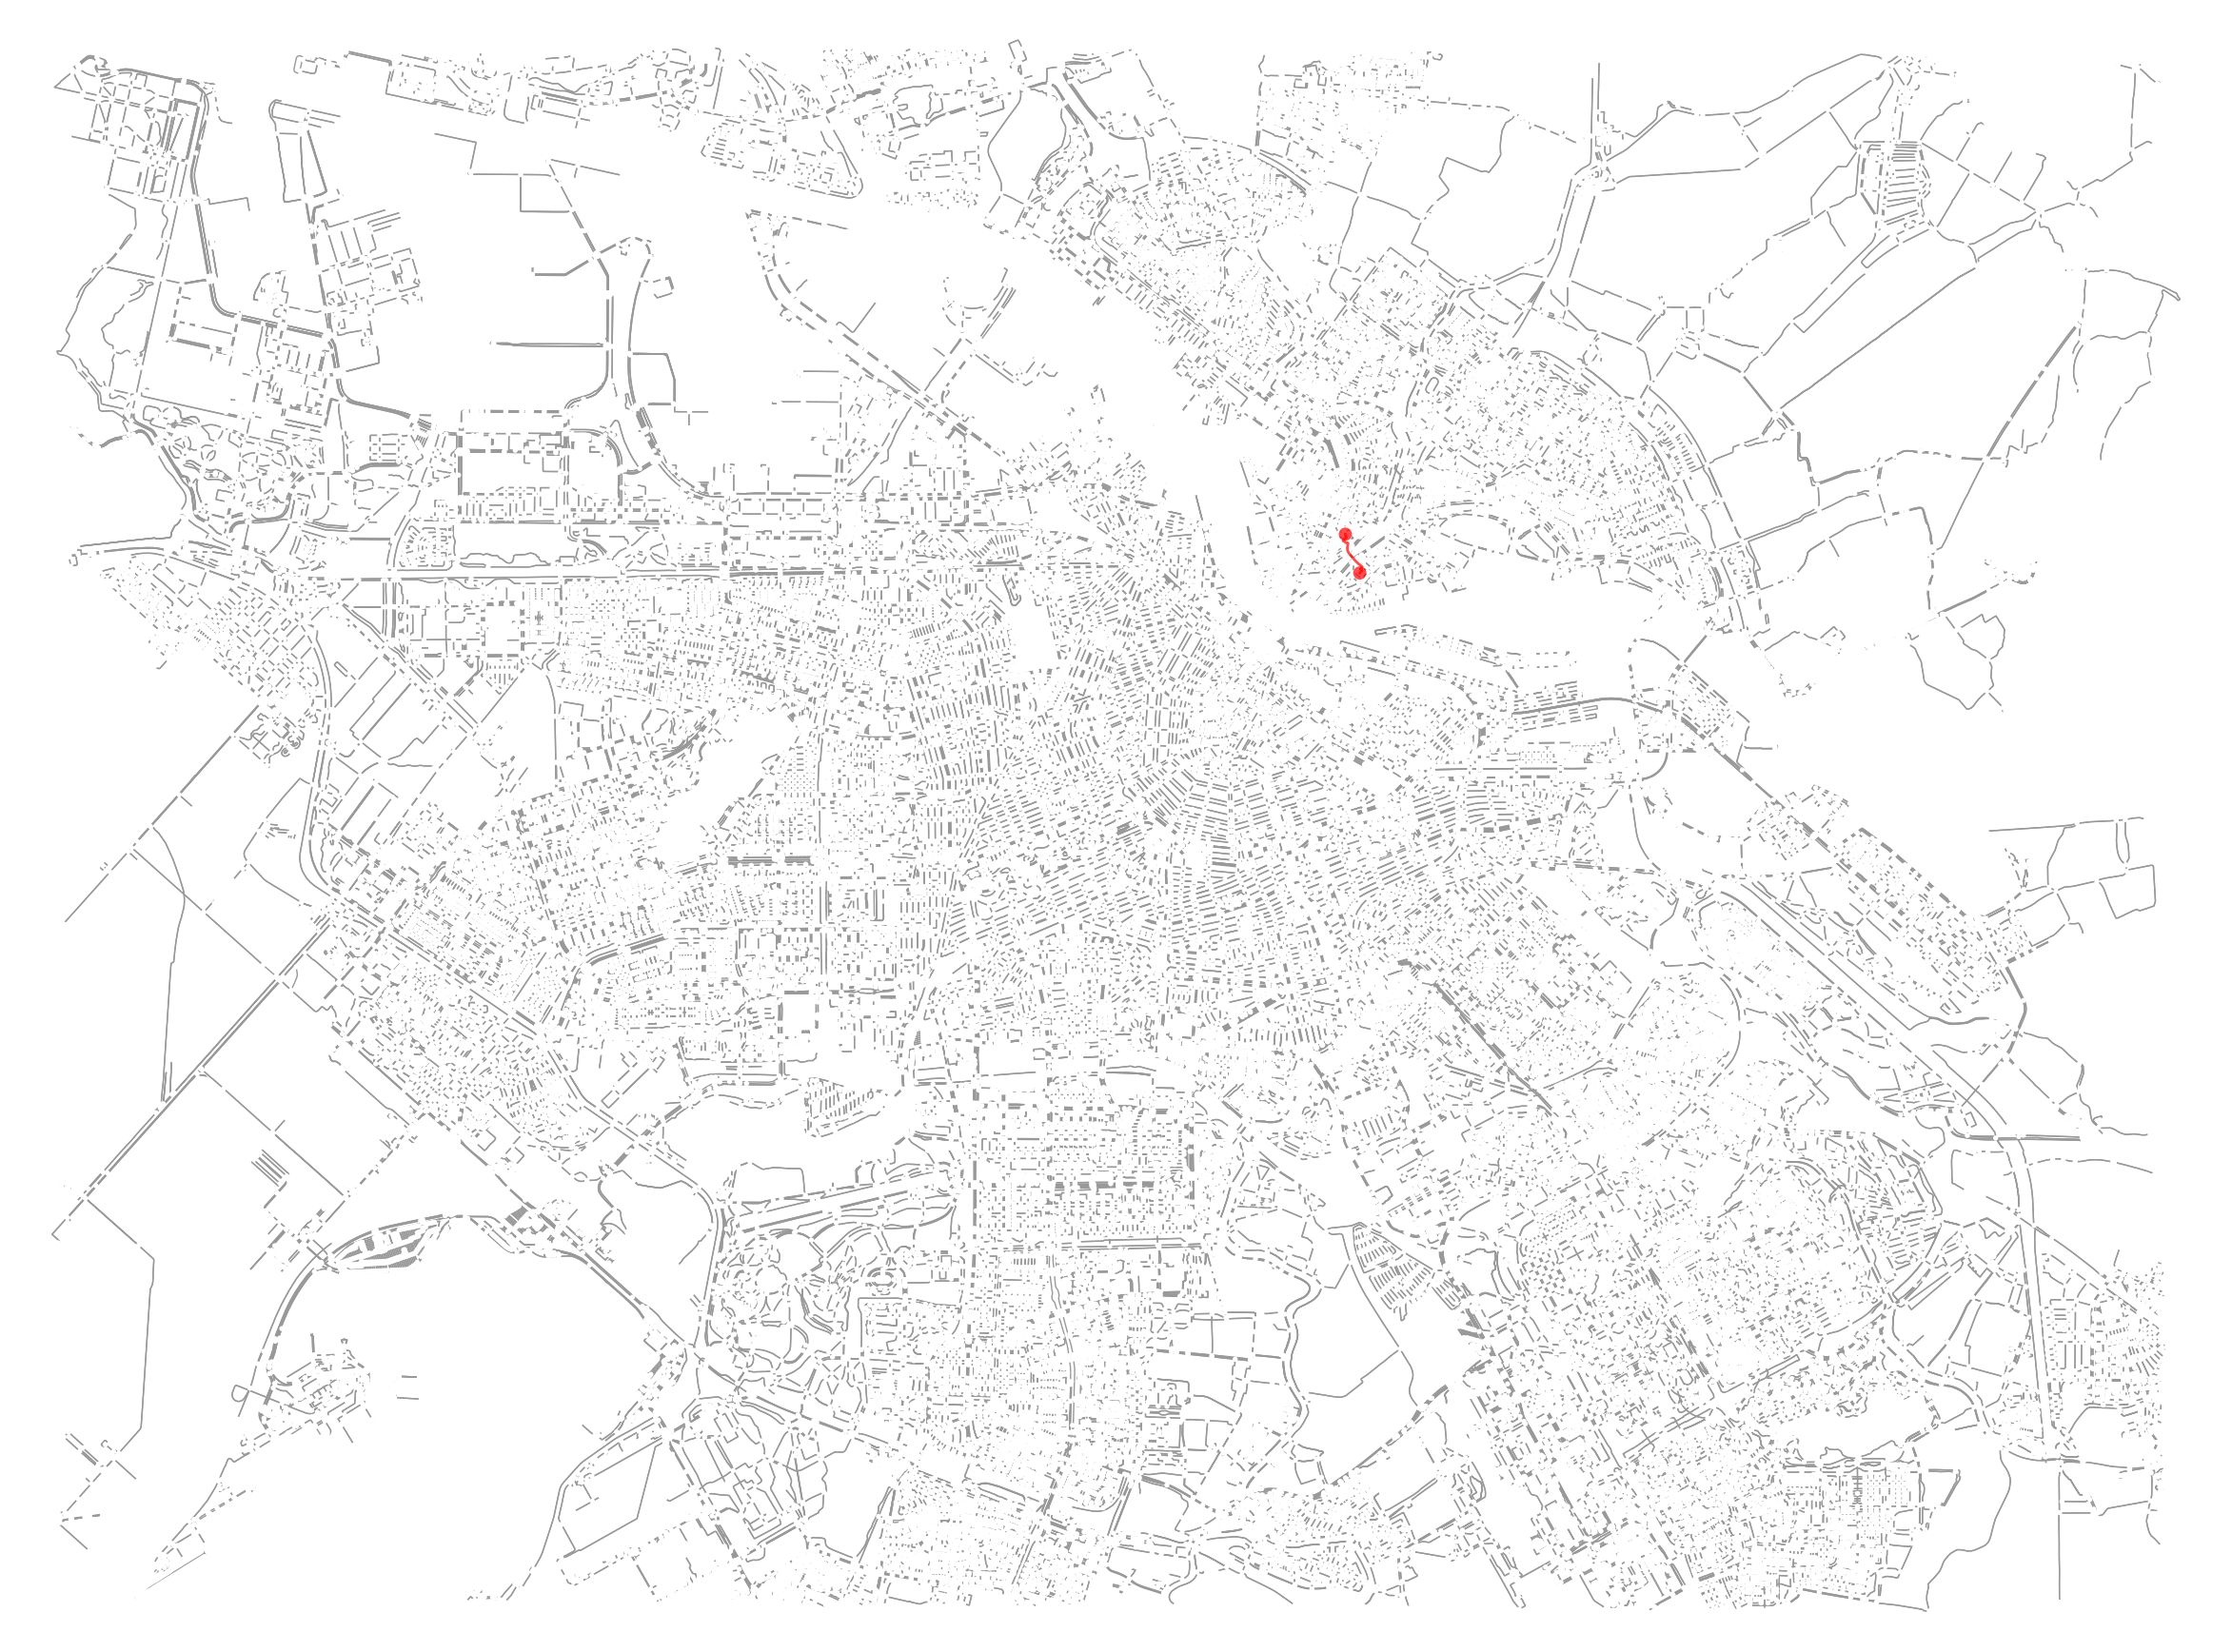

In [90]:
origin_node_2 = 11184651937
destination_node_2 = 11274852194	
routes_2 = []
shady_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='shade_weight')
shortest_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='length')


margin = 2000
bounding_box = (
    123382 - margin,
    489263 - margin, 
    123516 + margin, 
    489602 + margin)



fig, ax = plt.subplots(figsize=(30,30))

ox.plot_graph(graph, ax=ax, show=False, close=False)
ox.plot_graph_route(graph, shady_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='r', ax=ax)
ox.plot_graph_route(graph, shortest_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='g', ax=ax)
minx, miny, maxx, maxy = bounding_box
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

/opt/anaconda3/envs/cds_new/lib/python3.11/site-packages/osmnx/routing.py:74: UserWarning: The attribute 'shade_weight' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


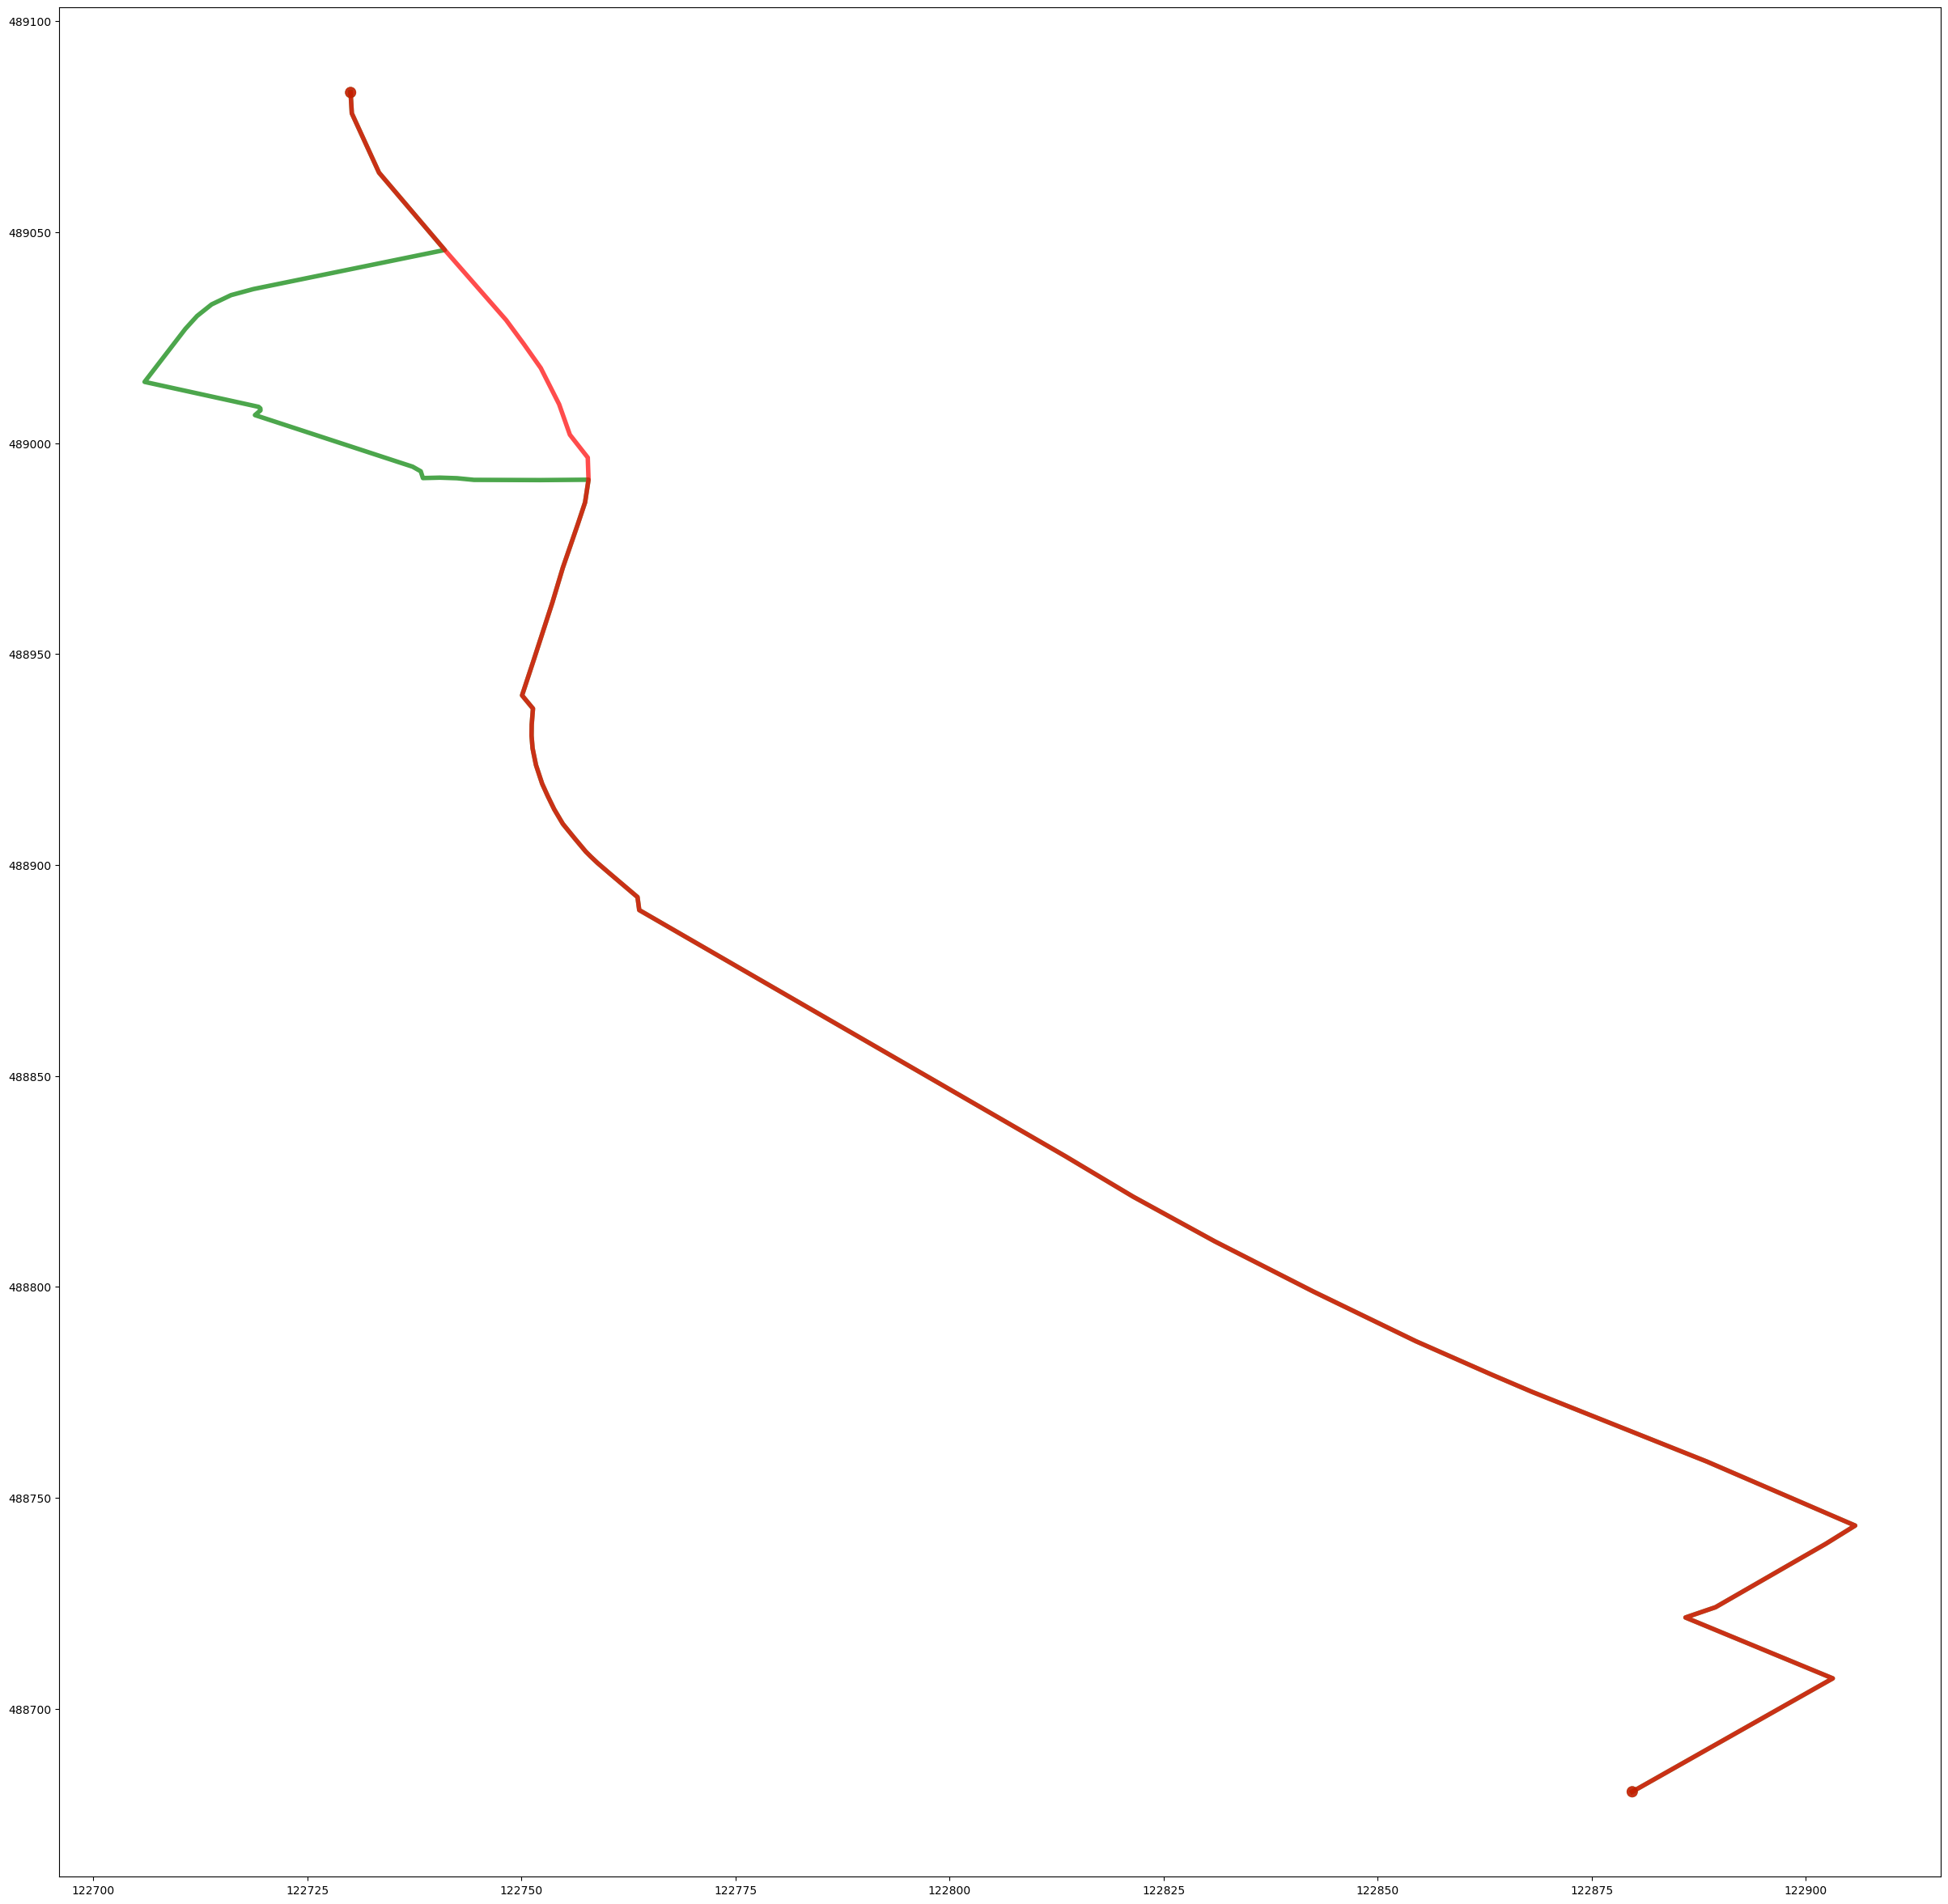

In [98]:
# Assuming 'graph' is already created using osmnx and 'ox' is imported as shown

# Define origin and destination nodes
origin_node_2 = 11184651937
destination_node_2 = 11274852194

# Calculate routes
shady_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='shade_weight')
shortest_route = ox.shortest_path(graph, origin_node_2, destination_node_2, weight='length')

# Margin for bounding box
margin = 0.01  # Small margin in degrees

# Get positions of the origin and destination nodes
origin_point = (graph.nodes[origin_node_2]['y'], graph.nodes[origin_node_2]['x'])
destination_point = (graph.nodes[destination_node_2]['y'], graph.nodes[destination_node_2]['x'])

# Calculate bounding box based on origin and destination coordinates
minx = min(origin_point[1], destination_point[1]) - margin
maxx = max(origin_point[1], destination_point[1]) + margin
miny = min(origin_point[0], destination_point[0]) - margin
maxy = max(origin_point[0], destination_point[0]) + margin

# Create plot
fig, ax = plt.subplots(figsize=(30, 30))

# # Plot the graph
# ox.plot_graph(graph, ax=ax, show=False, close=False)
routes = [shady_route,shortest_route]
# # Plot routes
# ox.plot_graph_route(graph, shady_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='r', ax=ax)
# ox.plot_graph_route(graph, shortest_route, route_linewidth=2, route_alpha=0.7, orig_dest_node_color='g', ax=ax)

ox.plot_graph_routes(graph, routes, route_colors=['g','r'], route_linewidth=2, route_alpha=0.7, ax=ax)

# Set limits for the bounding box
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Show plot
plt.show()


# TO DO
- gather nearest node of centroid for noorderpark (single point)
- gather nearest node of cbs grid points that are nearest to noorderpark (single point)
- run the shortest route of single nn of centroid grid to single nn of centroid park
- run the shadiest route of single nn of centroid grid to single nn of centroid park
- calculate routes and differences (lengths) 
- work on mapping view for each matplot

In [106]:
# import upd csv 
upd_nodes = pd.read_csv('upd_nodes.csv')
upd_nodes.head()

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,LNG,LAT,nearest_node,centroid,geometry_node,centroid_node,route,routes_lengths
0,E1114N4905,5,-99997,-99997,POINT (111450 490550),1406.494978,123,123,Geuzenbos,"POLYGON((4.771969 52.394257,4.771798 52.394177...",4.764703,52.394247,4.648924e+07,POINT (112628.39600468897 489782.1386973135),8660241298,46489238,"[8660241298, 9349309030, 6060705141, 180651160...",2322.628
1,E1123N4874,5,5,-99997,POINT (112350 487450),1213.423143,63,63,Lutkemeerpark,"POLYGON((4.760765 52.369727,4.760959 52.36982,...",4.761132,52.362362,1.766461e+09,POINT (112354.6486519007 486236.58576145174),7887227317,1766461007,"[7887227317, 11046703638, 413575415, 482485033...",1492.392
2,E1123N4882,30,15,15,POINT (112350 488250),1557.226163,123,123,Geuzenbos,"POLYGON((4.771969 52.394257,4.771798 52.394177...",4.764703,52.394247,4.648924e+07,POINT (112628.39600468897 489782.1386973135),4987111323,46489238,"[4987111323, 2622501668, 46430889, 46432171, 1...",3319.369
3,E1123N4883,5,-99997,-99997,POINT (112350 488350),1458.946738,123,123,Geuzenbos,"POLYGON((4.771969 52.394257,4.771798 52.394177...",4.764703,52.394247,4.648924e+07,POINT (112628.39600468897 489782.1386973135),3810657876,46489238,"[3810657876, 46432171, 1448037372, 8959767377,...",3276.149
4,E1124N4875,10,-99997,5,POINT (112450 487550),1316.870852,63,63,Lutkemeerpark,"POLYGON((4.760765 52.369727,4.760959 52.36982,...",4.761132,52.362362,1.766461e+09,POINT (112354.6486519007 486236.58576145174),7887227317,1766461007,"[7887227317, 11046703638, 413575415, 482485033...",1492.392


In [107]:
noord_df = upd_nodes[upd_nodes['Naam']== 'Noorderpark']
noord_df

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,LNG,LAT,nearest_node,centroid,geometry_node,centroid_node,route,routes_lengths
3640,E1217N4897,80,45,35,POINT (121750 489750),1477.869974,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),6066265663,2614599183,"[6066265663, 6920511303, 2849361939, 119565434...",1831.081
3704,E1218N4887,110,60,50,POINT (121850 488750),1675.295789,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),10741581904,2614599183,"[10741581904, 1367580245, 678459366, 111459093...",2043.592
3705,E1218N4888,205,110,95,POINT (121850 488850),1620.438609,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),11145909377,2614599183,"[11145909377, 9727960036, 6796780750, 67967807...",1946.499
3706,E1218N4889,150,80,70,POINT (121850 488950),1570.040316,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),9727960041,2614599183,"[9727960041, 1956875652, 11178370864, 11148533...",1827.623
3707,E1218N4890,5,5,-99997,POINT (121850 489050),1524.543177,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),11237038434,2614599183,"[11237038434, 11237038432, 7702594893, 8473841...",1704.410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,E1238N4900,245,135,115,POINT (123850 490050),712.511507,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),8192140253,2614599183,"[8192140253, 8192140287, 8192140252, 46497861,...",1423.057
4905,E1238N4901,255,130,120,POINT (123850 490150),766.079601,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),5741537066,2614599183,"[5741537066, 5741537062, 5741537064, 133440813...",1521.520
4906,E1238N4902,75,30,45,POINT (123850 490250),828.301432,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),5741537065,2614599183,"[5741537065, 5741537064, 1334408135, 700727944...",1517.829
4946,E1239N4899,65,30,35,POINT (123950 489950),763.568416,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",4.920416,52.394261,360859911.0,POINT (123227.15307930086 489703.9734667814),4495350412,2614599183,"[4495350412, 46494275, 1678401408, 988913468, ...",1408.872


In [133]:
def calculate_routes(gdf, graph,origin_column,destination_column):
    """
    Calculate the shortest and shadiest routes between origin nodes (CBS grid centroids) and destination nodes (Amsterdam's park centroids) in a gdf.
    Parameters:
        - gdf: contains origin and destination nodes
        - graph: osmnx multidigraph representing bike + walk network for network typology analysis
        - origin_column: name of column containing origin nodes
        - destination_column: name of column containing dest nodes

        Returns:
        - new_gdf or results: gdf with columns containing route information
    """
    #Route information
    pathway_nodes_shortest = []
    pathway_edges_shortest = []
    distance_shortest = []
    weight_shortest = []

    pathway_nodes_shadiest = []
    pathway_edges_shadiest = []
    distance_shadiest = []
    weight_shadiest = []

    # Check if 'shade_weight' exists in the graph
    has_shade_weight = any('shade_weight' in data for u, v, data in graph.edges(data=True))

    for index, row in gdf.iterrows():
        origin_node = row[f'{origin_column}']
        destination_node = row [f'{destination_column}']

        #Shortest route calculations
        try:
            shortest_path = ox.shortest_path(graph, origin_node, destination_node, weight='length')
            if shortest_path is not None and len(shortest_path)>1:
                shortest_path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
                shortest_distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
        
                if has_shade_weight:
                    shortest_weight= sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'shade_weight', retrieve_default=lambda u, v: 0))
                else:
                    shortest_weight = None
            else:
                # If there's no path or node is not found
                shortest_path = []
                shortest_path_edges = []
                shortest_distance = float('inf')
                shortest_weight = None
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            shortest_path = []
            shortest_path_edges = []
            shortest_distance = float('inf')
            shortest_weight = None
        
        # Calculate the shadiest route
        try:
            if has_shade_weight:
                shadiest_path = ox.shortest_path(graph, origin_node, destination_node, weight='shade_weight')
                if shadiest_path is not None and len(shadiest_path) >1:
                    shadiest_path_edges = list(zip(shadiest_path[:-1], shadiest_path[1:]))
                    shadiest_distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shadiest_path, 'length'))
                    shadiest_weight = sum(ox.utils_graph.get_route_edge_attributes(graph, shadiest_path, 'shade_weight', retrieve_default=lambda u, v:0))
                else:
                    shadiest_path = []
                    shadiest_path_edges = []
                    shadiest_distance = float('inf')
                    shadiest_weight = None
            else:
                shadiest_path = []
                shadiest_path_edges = []
                shadiest_distance = float('inf')
                shadiest_weight = None
        except (nx.NetworkXNoPath, nx.NodeNotFound) as e:
            # If there's no path or node is not found
            shadiest_path = []
            shadiest_path_edges = []
            shadiest_distance = float('inf')
            shadiest_weight = None

        pathway_nodes_shortest.append(shortest_path)
        pathway_edges_shortest.append(shortest_path_edges)
        distance_shortest.append(shortest_distance)
        weight_shortest.append(shortest_weight)

        pathway_nodes_shadiest.append(shadiest_path)
        pathway_edges_shadiest.append(shadiest_path_edges)
        distance_shadiest.append(shadiest_distance)
        weight_shadiest.append(shadiest_weight)
    
    new_gdf = gdf.copy()
    new_gdf['pathway_nodes_shortest'] = pathway_nodes_shortest
    new_gdf['pathway_edges_shortest'] = pathway_edges_shortest
    new_gdf['distance_shortest'] = distance_shortest
    new_gdf['weight_shortest'] = weight_shortest

    new_gdf['pathway_nodes_shadiest'] = pathway_nodes_shadiest
    new_gdf['pathway_edges_shadiest'] = pathway_edges_shadiest
    new_gdf['distance_shadiest'] = distance_shadiest
    new_gdf['weight_shadiest'] = weight_shadiest

    return new_gdf


result = calculate_routes(noord_df,graph,'geometry_node','centroid_node')

/var/folders/8r/hvp9tj_51dxfsj2f7_8kczh80000gn/T/ipykernel_29338/219384979.py:36: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  shortest_distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
/var/folders/8r/hvp9tj_51dxfsj2f7_8kczh80000gn/T/ipykernel_29338/219384979.py:39: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  shortest_weight= sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'shade_weight', retrieve_default=lambda u, v: 0))
/opt/anaconda3/envs/cds_new/lib/python3.11/site-packages/osmnx/routing.py:74: UserWarning: The attribute '

In [134]:
result

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,...,route,routes_lengths,pathway_nodes_shortest,pathway_edges_shortest,distance_shortest,weight_shortest,pathway_nodes_shadiest,pathway_edges_shadiest,distance_shadiest,weight_shadiest
3640,E1217N4897,80,45,35,POINT (121750 489750),1477.869974,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[6066265663, 6920511303, 2849361939, 119565434...",1831.081,"[6066265663, 6920511303, 2849361939, 119565434...","[(6066265663, 6920511303), (6920511303, 284936...",1831.081,96.811487,"[6066265663, 6920511303, 6066265671, 606626567...","[(6066265663, 6920511303), (6920511303, 606626...",2727.034,39.366457
3704,E1218N4887,110,60,50,POINT (121850 488750),1675.295789,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[10741581904, 1367580245, 678459366, 111459093...",2043.592,"[10741581904, 1367580245, 678459366, 111459093...","[(10741581904, 1367580245), (1367580245, 67845...",2043.592,73.343025,"[10741581904, 1367580245, 5625404154, 11168103...","[(10741581904, 1367580245), (1367580245, 56254...",2638.425,25.713690
3705,E1218N4888,205,110,95,POINT (121850 488850),1620.438609,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[11145909377, 9727960036, 6796780750, 67967807...",1946.499,"[11145909377, 9727960036, 6796780750, 67967807...","[(11145909377, 9727960036), (9727960036, 67967...",1946.499,78.351528,"[11145909377, 678459366, 1367580245, 562540415...","[(11145909377, 678459366), (678459366, 1367580...",2666.325,27.221573
3706,E1218N4889,150,80,70,POINT (121850 488950),1570.040316,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[9727960041, 1956875652, 11178370864, 11148533...",1827.623,"[9727960041, 1956875652, 11178370864, 11148533...","[(9727960041, 1956875652), (1956875652, 111783...",1827.623,68.485720,"[9727960041, 11148062966, 678459366, 136758024...","[(9727960041, 11148062966), (11148062966, 6784...",2782.792,29.068035
3707,E1218N4890,5,5,-99997,POINT (121850 489050),1524.543177,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[11237038434, 11237038432, 7702594893, 8473841...",1704.410,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",1704.410,67.127694,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",2487.442,30.594965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,E1238N4900,245,135,115,POINT (123850 490050),712.511507,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[8192140253, 8192140287, 8192140252, 46497861,...",1423.057,"[8192140253, 8192140287, 8192140252, 46497861,...","[(8192140253, 8192140287), (8192140287, 819214...",1423.057,23.831609,"[8192140253, 8192140255, 46497467, 46495864, 4...","[(8192140253, 8192140255), (8192140255, 464974...",1548.019,17.565828
4905,E1238N4901,255,130,120,POINT (123850 490150),766.079601,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[5741537066, 5741537062, 5741537064, 133440813...",1521.520,"[5741537066, 5741537062, 5741537064, 133440813...","[(5741537066, 5741537062), (5741537062, 574153...",1521.520,21.678341,"[5741537066, 5741537062, 5741537064, 46499646,...","[(5741537066, 5741537062), (5741537062, 574153...",1843.352,17.278563
4906,E1238N4902,75,30,45,POINT (123850 490250),828.301432,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[5741537065, 5741537064, 1334408135, 700727944...",1517.829,"[5741537065, 5741537064, 1334408135, 700727944...","[(5741537065, 5741537064), (5741537064, 133440...",1517.829,22.935944,"[5741537065, 5741537064, 46499646, 441218034, ...","[(5741537065, 5741537064), (5741537064, 464996...",1839.661,18.536166
4946,E1239N4899,65,30,35,POINT (123950 489950)

In [135]:
result['distance_difference'] = result['distance_shadiest'] - result['distance_shortest']
result

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,...,routes_lengths,pathway_nodes_shortest,pathway_edges_shortest,distance_shortest,weight_shortest,pathway_nodes_shadiest,pathway_edges_shadiest,distance_shadiest,weight_shadiest,distance_difference
3640,E1217N4897,80,45,35,POINT (121750 489750),1477.869974,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1831.081,"[6066265663, 6920511303, 2849361939, 119565434...","[(6066265663, 6920511303), (6920511303, 284936...",1831.081,96.811487,"[6066265663, 6920511303, 6066265671, 606626567...","[(6066265663, 6920511303), (6920511303, 606626...",2727.034,39.366457,895.953
3704,E1218N4887,110,60,50,POINT (121850 488750),1675.295789,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,2043.592,"[10741581904, 1367580245, 678459366, 111459093...","[(10741581904, 1367580245), (1367580245, 67845...",2043.592,73.343025,"[10741581904, 1367580245, 5625404154, 11168103...","[(10741581904, 1367580245), (1367580245, 56254...",2638.425,25.713690,594.833
3705,E1218N4888,205,110,95,POINT (121850 488850),1620.438609,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1946.499,"[11145909377, 9727960036, 6796780750, 67967807...","[(11145909377, 9727960036), (9727960036, 67967...",1946.499,78.351528,"[11145909377, 678459366, 1367580245, 562540415...","[(11145909377, 678459366), (678459366, 1367580...",2666.325,27.221573,719.826
3706,E1218N4889,150,80,70,POINT (121850 488950),1570.040316,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1827.623,"[9727960041, 1956875652, 11178370864, 11148533...","[(9727960041, 1956875652), (1956875652, 111783...",1827.623,68.485720,"[9727960041, 11148062966, 678459366, 136758024...","[(9727960041, 11148062966), (11148062966, 6784...",2782.792,29.068035,955.169
3707,E1218N4890,5,5,-99997,POINT (121850 489050),1524.543177,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1704.410,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",1704.410,67.127694,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",2487.442,30.594965,783.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,E1238N4900,245,135,115,POINT (123850 490050),712.511507,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1423.057,"[8192140253, 8192140287, 8192140252, 46497861,...","[(8192140253, 8192140287), (8192140287, 819214...",1423.057,23.831609,"[8192140253, 8192140255, 46497467, 46495864, 4...","[(8192140253, 8192140255), (8192140255, 464974...",1548.019,17.565828,124.962
4905,E1238N4901,255,130,120,POINT (123850 490150),766.079601,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1521.520,"[5741537066, 5741537062, 5741537064, 133440813...","[(5741537066, 5741537062), (5741537062, 574153...",1521.520,21.678341,"[5741537066, 5741537062, 5741537064, 46499646,...","[(5741537066, 5741537062), (5741537062, 574153...",1843.352,17.278563,321.832
4906,E1238N4902,75,30,45,POINT (123850 490250),828.301432,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1517.829,"[5741537065, 5741537064, 1334408135, 700727944...","[(5741537065, 5741537064), (5741537064, 133440...",1517.829,22.935944,"[5741537065, 5741537064, 46499646, 441218034, ...","[(5741537065, 5741537064), (5741537064, 464996...",1839.661,18.536166,321.832
4946,E1239N4899,65,30,35,POINT (123950 489950),763.568416,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1408.872,"[4495350412, 46494275, 1678401408, 988913468, ...","[(4495350412, 46494275), (46494275, 1678401408...",1408.872,35.744031,"[4495350412, 46494275, 1678401408, 988913468, ...","[(4495350412, 46494275), (46494275, 1678401408...",1524.606,13.8660

In [141]:
result.to_csv('noorderpark_routes.csv', index =False)
# import upd csv 
noorderpark_routes = pd.read_csv('noorderpark_routes.csv')
noorderpark_routes.head()

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,...,routes_lengths,pathway_nodes_shortest,pathway_edges_shortest,distance_shortest,weight_shortest,pathway_nodes_shadiest,pathway_edges_shadiest,distance_shadiest,weight_shadiest,distance_difference
0,E1217N4897,80,45,35,POINT (121750 489750),1477.869974,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1831.081,"[6066265663, 6920511303, 2849361939, 119565434...","[(6066265663, 6920511303), (6920511303, 284936...",1831.081,96.811487,"[6066265663, 6920511303, 6066265671, 606626567...","[(6066265663, 6920511303), (6920511303, 606626...",2727.034,39.366457,895.953
1,E1218N4887,110,60,50,POINT (121850 488750),1675.295789,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,2043.592,"[10741581904, 1367580245, 678459366, 111459093...","[(10741581904, 1367580245), (1367580245, 67845...",2043.592,73.343025,"[10741581904, 1367580245, 5625404154, 11168103...","[(10741581904, 1367580245), (1367580245, 56254...",2638.425,25.713690,594.833
2,E1218N4888,205,110,95,POINT (121850 488850),1620.438609,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1946.499,"[11145909377, 9727960036, 6796780750, 67967807...","[(11145909377, 9727960036), (9727960036, 67967...",1946.499,78.351528,"[11145909377, 678459366, 1367580245, 562540415...","[(11145909377, 678459366), (678459366, 1367580...",2666.325,27.221573,719.826
3,E1218N4889,150,80,70,POINT (121850 488950),1570.040316,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1827.623,"[9727960041, 1956875652, 11178370864, 11148533...","[(9727960041, 1956875652), (1956875652, 111783...",1827.623,68.485720,"[9727960041, 11148062966, 678459366, 136758024...","[(9727960041, 11148062966), (11148062966, 6784...",2782.792,29.068035,955.169
4,E1218N4890,5,5,-99997,POINT (121850 489050),1524.543177,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,1704.410,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",1704.410,67.127694,"[11237038434, 11237038432, 7702594893, 8473841...","[(11237038434, 11237038432), (11237038432, 770...",2487.442,30.594965,783.032


In [114]:
result[0:1]

,crs28992res100m,aantal_inwoners,aantal_mannen,aantal_vrouwen,geometry,distance_to_nearest_park,nearest_park_objectnummer,OBJECTNUMMER,Naam,WKT_LNG_LAT,...,route,routes_lengths,pathway_nodes_shortest,pathway_edges_shortest,distance_shortest,weight_shortest,pathway_nodes_shadiest,pathway_edges_shadiest,distance_shadiest,weight_shadiest
3640,E1217N4897,80,45,35,POINT (121750 489750),1477.869974,28,28,Noorderpark,"MULTIPOLYGON(((4.921972 52.396575,4.921958 52....",...,"[6066265663, 6920511303, 2849361939, 119565434...",1831.081,"[6066265663, 6920511303, 2849361939, 119565434...","[(6066265663, 6920511303), (6920511303, 284936...",1831.081,96.811487,"[6066265663, 6920511303, 6066265671, 606626567...","[(6066265663, 6920511303), (6920511303, 606626...",2727.034,39.366457


In [145]:
noorderpark_gdf = gpd.read_file('noorderpark_gdf.gpkg')
noorderpark_gdf_projected = noorderpark_gdf.copy()

from shapely import wkt
noorderpark_gdf_projected["WKT_LNG_LAT"] = noorderpark_gdf_projected["WKT_LNG_LAT"].apply(wkt.loads)
noorderpark_gdf_projected = noorderpark_gdf_projected.set_geometry("WKT_LNG_LAT").set_crs("epsg:4326")
noorderpark_gdf_projected = noorderpark_gdf_projected.to_crs("EPSG:28992")

/var/folders/8r/hvp9tj_51dxfsj2f7_8kczh80000gn/T/ipykernel_29338/961050269.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left')


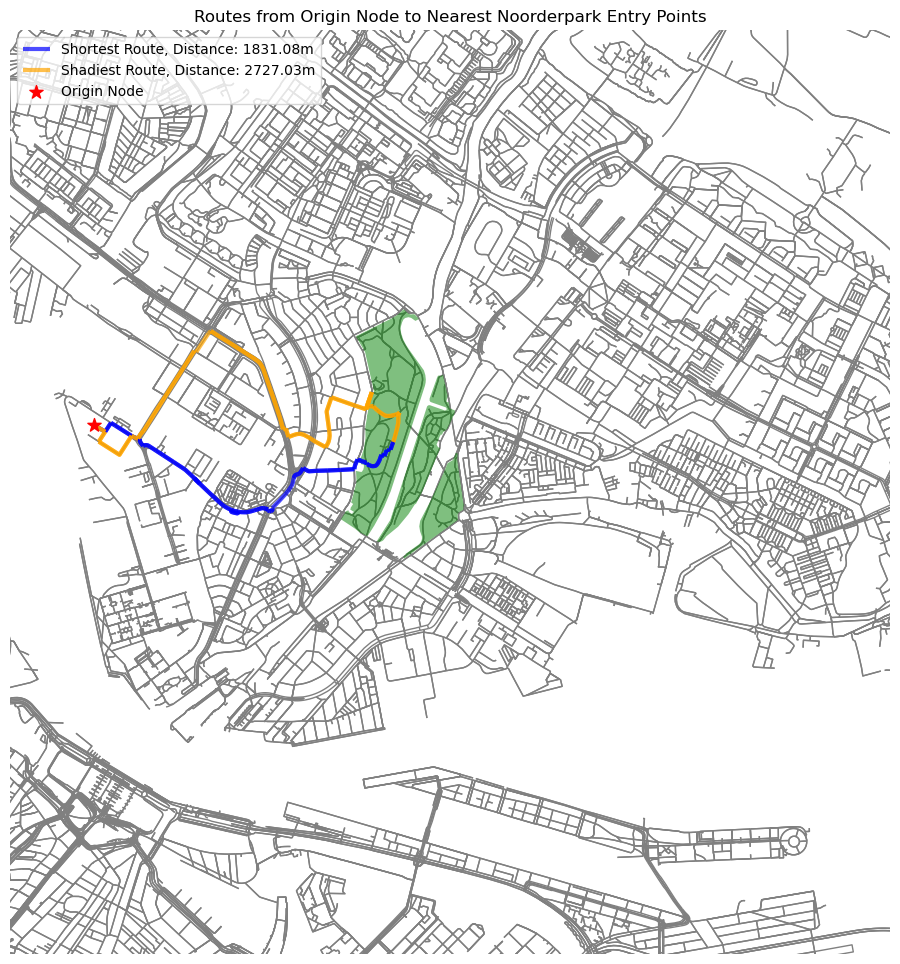

In [148]:
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd

def plot_routes_simple(G, gdf, bbox, noorderpark_gdf_projected):
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the graph with no nodes displayed
    ox.plot_graph(G, ax=ax, node_size=0, edge_color='gray', show=False, close=False)

    # Use two distinct colors for the routes
    shortest_route_color = 'blue'
    shadiest_route_color = 'orange'

    # Get the first row (since you mentioned it's the test case)
    row = gdf.iloc[0]

    # Plot the shortest route
    route_nodes_shortest = row['pathway_nodes_shortest']
    route_geom_shortest = ox.graph_to_gdfs(G.subgraph(route_nodes_shortest), nodes=False)['geometry']
    route_geom_shortest.plot(ax=ax, linewidth=3, alpha=0.7, color=shortest_route_color, label=f"Shortest Route, Distance: {row['distance_shortest']:.2f}m")

    # Plot the shadiest route
    route_nodes_shadiest = row['pathway_nodes_shadiest']
    route_geom_shadiest = ox.graph_to_gdfs(G.subgraph(route_nodes_shadiest), nodes=False)['geometry']
    route_geom_shadiest.plot(ax=ax, linewidth=3, alpha=0.7, color=shadiest_route_color, label=f"Shadiest Route, Distance: {row['distance_shadiest']:.2f}m")

    # Highlight the origin node
    origin_node = row['pathway_nodes_shortest'][0]  # Assuming the first node in the shortest route is the origin
    origin_point = G.nodes[origin_node]
    ax.scatter(
        origin_point['x'], origin_point['y'], 
        s=100, c='red', marker='*', zorder=5, label='Origin Node'
    )

    # Plot Noorderpark as its own polygon
    noorderpark_gdf_projected.plot(ax=ax, facecolor='green', alpha=0.5, linewidth=2, label='Noorderpark')

    # Set the bounding box to zoom in on the area of interest
    minx, miny, maxx, maxy = bbox
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add legend and title
    plt.legend(loc='upper left')
    plt.title('Routes from Origin Node to Nearest Noorderpark Entry Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Define the bounding box
margin = 2000
bounding_box = (
    123382 - margin,
    489263 - margin, 
    123516 + margin, 
    489602 + margin)

# Example usage (assuming the required graph and data are provided)

plot_routes_simple(graph, result, bounding_box, noorderpark_gdf_projected)
